In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import json
import pprint
from IPython.core.display import display
%matplotlib inline
import tweepy
import networkx as nx
import random
from pyvis.network import Network

from functions_file import *
#del Functions
import matplotlib.pyplot as plt
from pylab import rcParams
from networkx.algorithms.approximation import clique
from scipy import stats
data_folder = "data"
print("imported completed!")

imported completed!


In [2]:
consumer_key = "ilMCDSvsK2gQPzNpExcN9w0dj"
consumer_secret = "LJhNjYbJwHOcmzihgJDsaVIdYxgkCF3aezr4v1k9pQkoH9mmgl"
access_token = "426038638-16YAVtywETEPoD9F1M5P6I3IavaZwRUF3RdjVTGd"
access_secret = "n0G7Hddsjm9HAFvvNY1ntNQk475PUTJg4Ub8F1x6k8ozn"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAPUTJQEAAAAA8%2FTr01XqXtQ7NcaRUgtKtK2M%2BR0%3D7AByu1bjwYdcf0Xs7mOeVb6FKNCYEIW4VN16WMrB7CO7G1xXxU"

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
if api.verify_credentials :
  print ('Authentication completed successfully!')

Authentication completed successfully!


In [4]:
users = ["mizzaro","damiano10","Miccighel_","eglu81","KevinRoitero"]
usersId = Functions.usersID(users,api)
print(usersId)

[18932422, 132646210, 15750573, 19659370, 3036907250]


In [15]:
quantity = 10
index = 0
for idUser in usersId:
    followers = Functions.download_followers(idUser, quantity,api)
    Functions.serialize_json(data_folder,f"followers_{users[index]}.json", followers)
    index += 1

Data serialized to path: data/00followers_mizzaro.json
Data serialized to path: data/00followers_damiano10.json
Data serialized to path: data/00followers_Miccighel_.json
Data serialized to path: data/00followers_eglu81.json
Data serialized to path: data/00followers_KevinRoitero.json


In [58]:
quantity = 800
index = 0
for idUser in usersId:
    friends = Functions.download_following(idUser, quantity,api)
    Functions.serialize_json(data_folder,f"friends_{users[index]}.json", friends)
    index +=1

Data serialized to path: data/friendsLucaThomas.json


In [10]:
#creo vettore con tutti gli id degli utenti senza duplicazione
files = [
    f"{data_folder}/followers_damiano10.json",
    f"{data_folder}/followers_eglu81.json",
    f"{data_folder}/followers_Miccighel_.json",
    f"{data_folder}/followers_mizzaro.json",
    f"{data_folder}/followers_KevinRoitero.json"
]
# Estraggo per ogni utente 5 followers

randomUsers = 5
quantity = 10
followersOfFollowers = {}
for file in files:
    found = []
    followers = Functions.read_json(file)
    found = Functions.random_json_with_control(followers, randomUsers)
    for user in found:
        followersOfFollowers[user] = Functions.download_followers(user, quantity,api)

Functions.serialize_json(data_folder,"followersOfFollowers.json", followersOfFollowers)

Data read fron path: data/followers_damiano10.json
Data read fron path: data/followers_eglu81.json
Data read fron path: data/followers_Miccighel_.json
Data read fron path: data/followers_mizzaro.json
Data read fron path: data/followers_KevinRoitero.json
Data serialized to path: data/followersOfFollowers.json


Rate limit reached. Sleeping for: 860
Rate limit reached. Sleeping for: 894


In [62]:
files = [
    f"{data_folder}/friends_damiano10.json",
    f"{data_folder}/friends_eglu81.json",
    f"{data_folder}/friends_Miccighel_.json",
    f"{data_folder}/friends_mizzaro.json",
    f"{data_folder}/friends_KevinRoitero.json"
]
# Estraggo per ogni utente 5 followers
randomUsers = 5
quantity = 10
friendsOfFriends = {}
for file in files:
    found = []
    friends = Functions.read_json(file)
    found = Functions.random_json_with_control(friends, randomUsers)
    for user in found:
        friendsOfFriends[user] = Functions.download_following(user, quantity,api)

Functions.serialize_json(data_folder,"friendsOfFriends.json", friendsOfFriends)

Data read fron path: data/friendsLucaThomas.json
Data serialized to path: data/friendsOfFriends.json


In [6]:
file_names = [
    f"{data_folder}/followersOfFollowers.json",
    f"{data_folder}/friendsOfFriends.json",

    f"{data_folder}/followers_damiano10.json",
    f"{data_folder}/followers_eglu81.json",
    f"{data_folder}/followers_KevinRoitero.json",
    f"{data_folder}/followers_Miccighel_.json",
    f"{data_folder}/followers_mizzaro.json",

    f"{data_folder}/friends_damiano10.json",
    f"{data_folder}/friends_eglu81.json",
    f"{data_folder}/friends_KevinRoitero.json",
    f"{data_folder}/friends_Miccighel_.json",
    f"{data_folder}/friends_mizzaro.json"
]

#creo vettore con tutti gli id degli utenti senza duplicazione
noDuplicates =  Functions.deleteDuplicates(Functions.mergeFiles(file_names))

usersId = Functions.usersID(users,api)

for id in usersId:
    noDuplicates.remove(id)

Functions.serialize_json(data_folder,"noDuplicati.json", noDuplicates)

Data read fron path: data/followersOfFollowers.json
Data read fron path: data/friendsOfFriends.json
Data read fron path: data/followers_damiano10.json
Data read fron path: data/followers_eglu81.json
Data read fron path: data/followers_KevinRoitero.json
Data read fron path: data/followers_Miccighel_.json
Data read fron path: data/followers_mizzaro.json
Data read fron path: data/friends_damiano10.json
Data read fron path: data/friends_eglu81.json
Data read fron path: data/friends_KevinRoitero.json
Data read fron path: data/friends_Miccighel_.json
Data read fron path: data/friends_mizzaro.json
Data serialized to path: data/noDuplicati.json


In [ ]:
vector = Functions.read_json(f"{data_folder}/noDuplicati.json")
index = 0
usersDetails = {}
def downloadUserDetails(userId, api):
    try:
        json_data = api.get_user(userId)._json
        foundInfo = {
            'id': json_data['id'],
            'name': json_data['name'],
            'screen_name': json_data['screen_name'],
            'location': json_data['location'],
            'followers_count': json_data['followers_count'],
            'friends_count': json_data['friends_count']
        }
        return foundInfo
    except tweepy.error.TweepError:
        print(userId)

for userId in range(0,750):
    usersDetails[index] = downloadUserDetails(vector[userId],api)
    index = index + 1

df = pd.DataFrame.from_dict(usersDetails,orient='index')
display(df)
df.to_csv("usersDetailsAgu.csv", index=False, encoding='utf-8')

In [ ]:
def friendship(sourceid, targetid, api):
    try:
        friendship = api.show_friendship(source_id=sourceid, target_id=targetid)
        if friendship[0].following & friendship[0].followed_by:
            return "Both"
        else:
            if friendship[0].following:
                return "SourceToTarget"
            if friendship[0].followed_by:
                return "TargetToSource"
            return None
    except tweepy.error.TweepError:
        print("errore")
        print(targetid)
        return None

usersId = Functions.usersID(users,api)
list = Functions.read_json(f"{data_folder}/noDuplicati.json")
index = 0
sourceTarget =[]

for target in list:
    print(target)
    relation = friendship(usersId[3],target,api)
    if relation:
        foundFriendship = {
            "source": usersId[3],
            "target": target,
            "friendship": relation
        }
        sourceTarget.append(foundFriendship)

df = pd.DataFrame(sourceTarget)
display(df)
df.to_csv("sourceTarget.csv",index = False , encoding='utf-8')

In [35]:
dfUsersDetails = pd.read_csv("usersDetailsCheap.csv")
dfUsersFriendship = pd.read_csv("sourceTargetULTIMATE.csv")

graph = nx.DiGraph()

#aggiunta membri gruppo come attributi
graph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]

for index,row in dfUsersDetails.iterrows():
    graph.add_node(row['id'], name = row['name'],screen_name=row['screen_name'],location = row['location'],followers_count = row['followers_count'],friends_count = row['friends_count'])

for index, row in dfUsersFriendship.iterrows():
    if row["friendship"] == "SourceToTarget":
        graph.add_edge(row["source"], row["target"])
    elif row["friendship"] == "TargetToSource" :
        graph.add_edge(row["target"], row["source"])
    else :
        graph.add_edge(row["source"], row["target"])
        graph.add_edge(row["target"], row["source"])

nx.write_gpickle(graph,"data/orientedGraph.pkl")

In [36]:
dfUsersDetails = pd.read_csv("usersDetailsCheap.csv")
dfUsersFriendship = pd.read_csv("sourceTargetULTIMATE.csv")
display(dfUsersDetails)
display(dfUsersFriendship)

graph = nx.Graph()

#aggiunta membri gruppo come attributi
graph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]

for index,row in dfUsersDetails.iterrows():
    graph.add_node(row['id'], label = row['screen_name'],location = row['location'],followers_count = row['followers_count'],friends_count = row['friends_count'])

for index, row in dfUsersFriendship.iterrows():
    graph.add_edge(row["source"], row["target"],weight = 1,id = index)

nx.write_gpickle(graph,"data/unOrientedGraph.pkl")

,id,name,screen_name,location,followers_count,friends_count
0,989428140433866752,Innovation Center for Artificial Intelligence,ic4ai,"Amsterdam, The Netherlands",1079,15
1,984275749824638976,ielab,IELabGroup,"Brisbane, Queensland",75,66
2,3235806942,Justin Zobel,j_zob,"Melbourne, Victoria",86,13
3,862356144748204032,DESIRES2020,DESIRES_IR,"Venezia, Veneto",269,111
4,610026759,Rocío Cañamares,rcanamares,NaN,101,98
...,...,...,...,...,...,...
2705,48062712,Luigi Di Maio,luigidimaio,"Pomigliano d'Arco, Campania",698293,386
2706,54163837,Philipp Mayr,Philipp_Mayr,"Colonia, Germania",1024,328
2707,911297187664949248,Jeff Dean (@🏡),JeffDean,NaN,175712,4274
2708,2575124365,Daniel Garijo,dgarijov,NaN,526,245


,source,target,friendship
0,19659370,18932422,Both
1,19659370,132646210,Both
2,19659370,15750573,TargetToSource
3,19659370,1425336134,TargetToSource
4,19659370,918943909811769344,TargetToSource
...,...,...,...
3309,15750573,131526573,SourceToTarget
3310,15750573,13533662,SourceToTarget
3311,15750573,52352322,SourceToTarget
3312,15750573,58324434,SourceToTarget


In [37]:
#punto 6

graph = nx.read_gpickle("data/unOrientedGraph.pkl")

nt = Network(
    height="100%",
    width="100%",
    bgcolor="222222",
    font_color="white",
    heading="progetto"
)
nt.barnes_hut()
nt.from_nx(graph)
neighbor_map = nt.get_adj_list()
for node in nt.nodes:
    node["Value"] = len(neighbor_map[node['id']])
nt.show("grafico.html")

Grafo connesso
Centro:  [19659370, 132646210, 3036907250]
Diametro:  4
Raggio:  2
Grafo non bipartito


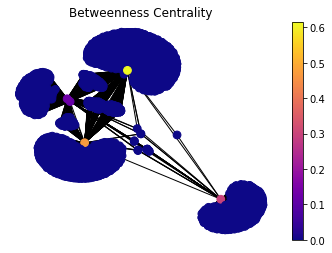

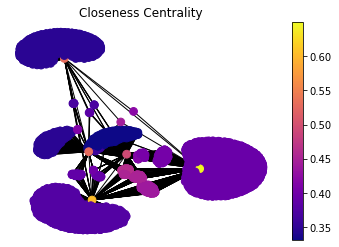

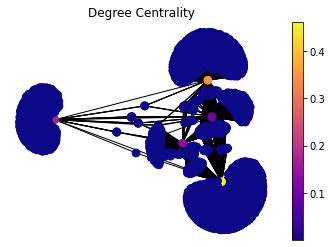

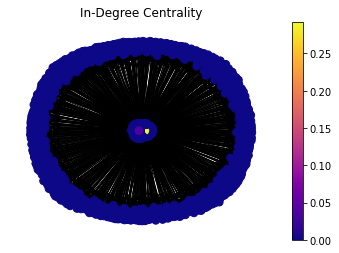

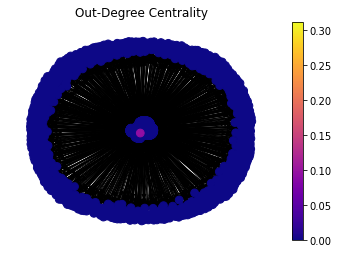

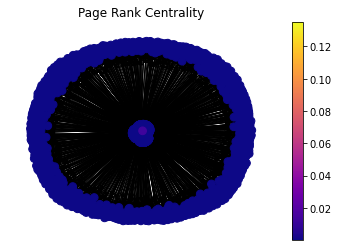

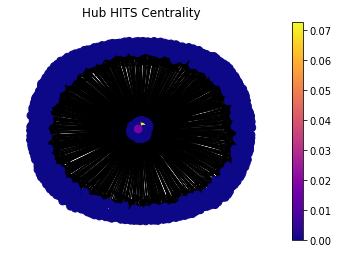

Data serialized to path: data/Betweenness.json
Data serialized to path: data/Closeness.json
Data serialized to path: data/Degree.json
Data serialized to path: data/In_degree.json
Data serialized to path: data/Out_degree.json
Data serialized to path: data/Pagerank.json
Data serialized to path: data/Hub.json
Data serialized to path: data/Authorities.json


In [8]:
from networkx.algorithms.distance_measures import center

def draw(G, pos, measures, measure_name):
    nodes = nx.draw_networkx_nodes(G,
                                   pos, 
                                   node_size=60, 
                                   cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys()
                                  )
    edges = nx.draw_networkx_edges(G,pos)
    #plt.figure(figsize=(10,10)) 
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis("off")
    plt.show()

unOriented = nx.read_gpickle("data/unOrientedGraph.pkl")
oriented = nx.read_gpickle("data/orientedGraph.pkl")


if(nx.is_connected(unOriented)):
    print("Grafo connesso"),
    print("Centro: ", end=" ")
    print(nx.center(unOriented))
    print("Diametro: ", end=" ")
    print(nx.diameter(unOriented))
    print("Raggio: ", end=" ")
    print(nx.radius(unOriented))

else:
    print("Grafo non connesso")


if(nx.is_bipartite(unOriented)):
    print("Grafo bipartito")
else:
    print("Grafo non bipartito")

bet = nx.betweenness_centrality(unOriented)
close = nx.closeness_centrality(unOriented)
degree = nx.degree_centrality(unOriented)
ind = nx.in_degree_centrality(oriented)
outd = nx.out_degree_centrality(oriented)
pr = nx.pagerank(oriented)
hub, authorities = nx.hits(oriented, max_iter=600)



draw(
    unOriented,
    nx.spring_layout(unOriented),
    bet,
    "Betweenness Centrality"
)
draw(
    unOriented,
    nx.spring_layout(unOriented),
    close,
    "Closeness Centrality"
)
draw(
    unOriented,
    nx.spring_layout(unOriented),
    degree,
    "Degree Centrality"
)
draw(
    oriented,
    nx.spring_layout(oriented),
    ind,
    "In-Degree Centrality"
)
draw(
    oriented,
    nx.spring_layout(oriented),
    outd,
    "Out-Degree Centrality"
)
draw(
    oriented,
    nx.spring_layout(oriented),
    pr,
    "Page Rank Centrality"
)
draw(
    oriented,
    nx.spring_layout(oriented),
    hub,
    "Hub HITS Centrality"
)









Functions.serialize_json(data_folder,"Betweenness.json", bet)
Functions.serialize_json(data_folder,"Closeness.json", close)
Functions.serialize_json(data_folder,"Degree.json", degree)
Functions.serialize_json(data_folder,"In_degree.json", ind)
Functions.serialize_json(data_folder,"Out_degree.json", outd)
Functions.serialize_json(data_folder,"Pagerank.json", pr)
Functions.serialize_json(data_folder,"Hub.json", hub)
Functions.serialize_json(data_folder,"Authorities.json", authorities)

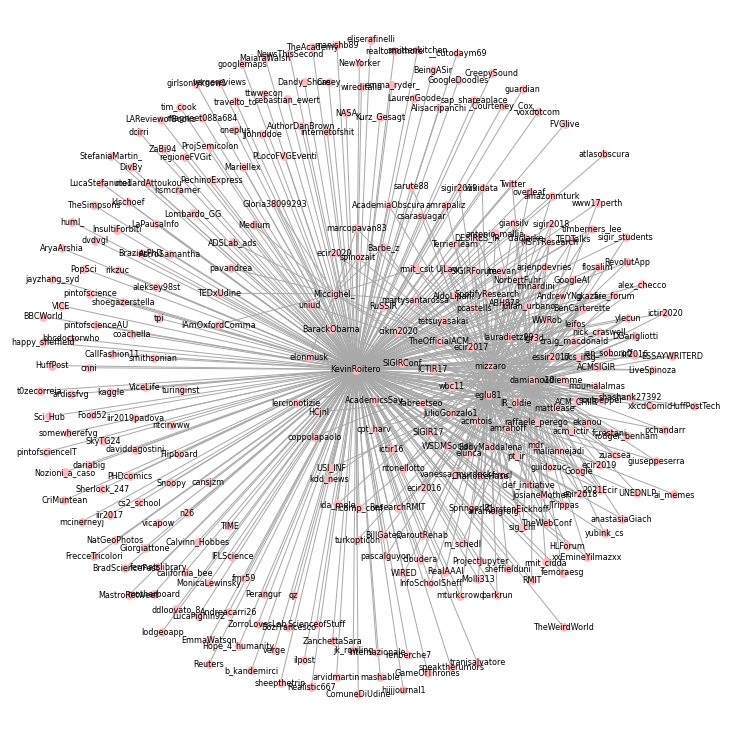

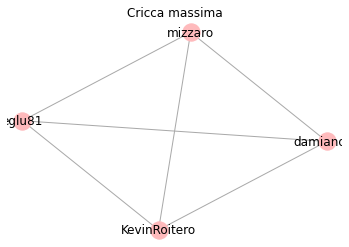

In [70]:
unOriented = nx.read_gpickle("data/UnOrientedGraph.pkl")

#genero sottografo
subgraph = nx.ego_graph(unOriented, Functions.userID("KevinRoitero",api), radius=1)


#cricca massima
print("Cricca massima: ", end=" ")
max_cl = clique.max_clique(subgraph)
print(max_cl)
print(" ")

#dimensione cricca massima
print("Dimensione della cricca massima: ", end=" ")
print(clique.large_clique_size(subgraph))
print(" ")


plt.figure(figsize=(10,10)) 

nx.draw(
    subgraph,
    labels = nx.get_node_attributes(subgraph, 'label'),
    pos = nx.spring_layout(subgraph),
    node_color = "#febabc",
    edge_color = "#A9A9A9",
    edge_cmap = plt.cm.Blues,
    node_size=60,
    font_size=8,
)

plt.savefig("data/subgraph.pdf")
plt.show()
plt.close()


clique_subgraph = subgraph.subgraph(max_cl)

ax = plt.gca()
ax.set_title('Cricca massima')

nx.draw(
    clique_subgraph,
    labels = nx.get_node_attributes(clique_subgraph, 'label'),
    pos = nx.spring_layout(clique_subgraph),
    node_color = "#febabc",
    edge_color = "#A9A9A9",
    edge_cmap = plt.cm.Blues,
    ax = ax
)

plt.show()
plt.close()

In [79]:
#copertura minima degli archi
unOriented = nx.read_gpickle("data/unOrientedGraph.pkl")
if(nx.is_connected(unOriented)):
    print("Copertura minima degli archi: ", end=" ")
    min_edge = nx.min_edge_cover(unOriented)
    #print(min_edge)
    print(" ")
    
    
    """
    ax = plt.gca()
    ax.set_title('Copertura minima')

    nx.draw(
        min_edge,
        #labels = nx.get_node_attributes(min_edge, 'label'),
        pos = nx.spring_layout(min_edge),
        node_color = "#febabc",
        edge_color = "#A9A9A9",
        edge_cmap = plt.cm.Blues,
        ax = ax
    )
    """
else:
    print("La copertura minima degli archi non si puo' calcolare")

Copertura minima degli archi:   


In [6]:
unOriented = nx.read_gpickle("data/unOrientedGraph.pkl")
print("Coefficiente omega: ", end=" ")
print(nx.omega(unOriented, niter=1, nrand=1, seed=1))
print(" ")
print("Coefficiente sigma: ", end=" ")
print(nx.sigma(unOriented, niter=1, nrand=1, seed=1))
print(" ")

Coefficiente omega:  0.0007776029985283595
 
Coefficiente sigma:  0.9824646158852525
 


In [80]:
#Punto 13 Correlazione di Pearson
bet = Functions.read_json(f"{data_folder}/Betweenness.json")
close = Functions.read_json(f"{data_folder}/Closeness.json")
degree = Functions.read_json(f"{data_folder}/Degree.json")
ind = Functions.read_json(f"{data_folder}/In_degree.json")
outd = Functions.read_json(f"{data_folder}/Out_degree.json")
pr = Functions.read_json(f"{data_folder}/Pagerank.json")
hub = Functions.read_json(f"{data_folder}/Hub.json")
authorities = Functions.read_json(f"{data_folder}/Authorities.json")
unOriented = nx.read_gpickle("data/unOrientedGraph.pkl")

allCent = [bet, close, degree, ind, outd, pr, hub, authorities]
allCent1 = np.empty((0,8), int)
dataTab = np.empty((0,8), int)

n_nodes = unOriented.number_of_nodes()

allCent1 = Functions.converterNumber(allCent, n_nodes)

tab = {}
tabTemp = {}
names = ["Betweenness", "Closeness", "Degree", "In-Degree", "Out-Degree", "Page Rank", "Hub", "Authorities"]
y = 0
res = []
#calcolo indice
for i in range(0,8):
    res.clear()
    for j in range(0,8):
        res.append(stats.stats.pearsonr(allCent1[i], allCent1[j]))

    x = 0
    tabTemp.clear()
    for re in res:
        nameCol = names[x]
        tabTemp[nameCol] = re
        x = x + 1

    nameRow = names[y]
    tab[nameRow] = tabTemp.copy()
    y = y + 1

df = pd.DataFrame.from_dict(tab,orient='index')
display(df)

Data read fron path: data/Betweenness.json
Data read fron path: data/Closeness.json
Data read fron path: data/Degree.json
Data read fron path: data/In_degree.json
Data read fron path: data/Out_degree.json
Data read fron path: data/Pagerank.json
Data read fron path: data/Hub.json
Data read fron path: data/Authorities.json


,Betweenness,Closeness,Degree,In-Degree,Out-Degree,Page Rank,Hub,Authorities
Betweenness,"(1.0, 0.0)","(0.2604452019723119, 2.9040551472239318e-43)","(0.9926763938193526, 0.0)","(0.9958744477131056, 0.0)","(0.9718476975733527, 0.0)","(0.9944827293343814, 0.0)","(0.9029840667797026, 0.0)","(0.34687797044781055, 1.807221776758965e-77)"
Closeness,"(0.2604452019723119, 2.9040551472239318e-43)","(0.9999999999999984, 0.0)","(0.2744457897594373, 4.9808512748969084e-48)","(0.27567733957884877, 1.8381128099833518e-48)","(0.2710301706418647, 7.697146139951068e-47)","(0.2645237439318934, 1.2708958389632246e-44)","(0.3398255671332247, 3.1212399865040745e-74)","(0.7087285384428912, 0.0)"
Degree,"(0.9926763938193526, 0.0)","(0.2744457897594373, 4.9808512748969084e-48)","(0.9999999999999984, 0.0)","(0.9915293030581619, 0.0)","(0.9927636939469308, 0.0)","(0.9858694948721268, 0.0)","(0.9394229962851337, 0.0)","(0.3654576066867286, 2.089903647602408e-86)"
In-Degree,"(0.9958744477131056, 0.0)","(0.27567733957884877, 1.8381128099833518e-48)","(0.9915293030581619, 0.0)","(1.0, 0.0)","(0.9713219286696614, 0.0)","(0.9989831609070415, 0.0)","(0.9148731336472338, 0.0)","(0.38246750853442585, 4.001445416461827e-95)"
Out-Degree,"(0.9718476975733527, 0.0)","(0.2710301706418647, 7.697146139951068e-47)","(0.9927636939469308, 0.0)","(0.9713219286696614, 0.0)","(0.9999999999999933, 0.0)","(0.9618304977929333, 0.0)","(0.9638577826226497, 0.0)","(0.35610105438851747, 7.861964358545473e-82)"
Page Rank,"(0.9944827293343814, 0.0)","(0.2645237439318934, 1.2708958389632246e-44)","(0.9858694948721268, 0.0)","(0.9989831609070415, 0.0)","(0.9618304977929333, 0.0)","(1.0, 0.0)","(0.9038274859392408, 0.0)","(0.3664636459159024, 6.5915452625601965e-87)"
Hub,"(0.9029840667797026, 0.0)","(0.3398255671332247, 3.1212399865040745e-74)","(0.9394229962851337, 0.0)","(0.9148731336472338, 0.0)","(0.9638577826226497, 0.0)","(0.9038274859392408, 0.0)","(0.9999999999999938, 0.0)","(0.36298583409013396, 3.49769324865253e-85)"
Authorities,"(0.34687797044781055, 1.807221776758965e-77)","(0.7087285384428912, 0.0)","(0.3654576066867286, 2.089903647602408e-86)","(0.38246750853442585, 4.001445416461827e-95)","(0.35610105438851747, 7.861964358545473e-82)","(0.3664636459159024, 6.5915452625601965e-87)","(0.36298583409013396, 3.49769324865253e-85)","(1.0, 0.0)"


In [71]:
#Punto 13 Correlazione di Kendall
bet = Functions.read_json(f"{data_folder}/Betweenness.json")
close = Functions.read_json(f"{data_folder}/Closeness.json")
degree = Functions.read_json(f"{data_folder}/Degree.json")
ind = Functions.read_json(f"{data_folder}/In_degree.json")
outd = Functions.read_json(f"{data_folder}/Out_degree.json")
pr = Functions.read_json(f"{data_folder}/Pagerank.json")
hub = Functions.read_json(f"{data_folder}/Hub.json")
authorities = Functions.read_json(f"{data_folder}/Authorities.json")
unOriented = nx.read_gpickle("data/unOrientedGraph.pkl")

allCent = [bet, close, degree, ind, outd, pr, hub, authorities]
res = []
allCent1 = np.empty((0,8), int)
dataTab = np.empty((0,8), int)

n_nodes = unOriented.number_of_nodes()

allCent1 = Functions.converterNumber(allCent, n_nodes)


tab = {}
tabTemp = {}
names = ["Betweenness", "Closeness", "Degree", "In-Degree", "Out-Degree", "Page Rank", "Hub", "Authorities"]
y = 0
tau = []
pvalue = []
#calcolo indice
for i in range(0,8):
    tau.clear()
    pvalue.clear()
    tabTemp.clear()
    for j in range(0,8):
        tauTemp, pvalueTemp = stats.kendalltau(allCent1[i], allCent1[j])
        tau.append(tauTemp)
        pvalue.append(pvalueTemp)
    x = 0
    tabTemp.clear()
    for ta in tau:
        nameCol = names[x]
        tabTemp[nameCol] = "(" + str(ta) + ", " + str(pvalue[x]) + ")"
        x = x + 1

    nameRow = names[y]
    tab[nameRow] = tabTemp.copy()
    y = y + 1

df = pd.DataFrame.from_dict(tab,orient='index')
display(df)

Data read fron path: data/Betweenness.json
Data read fron path: data/Closeness.json
Data read fron path: data/Degree.json
Data read fron path: data/In_degree.json
Data read fron path: data/Out_degree.json
Data read fron path: data/Pagerank.json
Data read fron path: data/Hub.json
Data read fron path: data/Authorities.json


,Betweenness,Closeness,Degree,In-Degree,Out-Degree,Page Rank,Hub,Authorities
Betweenness,"(1.0, 0.0)","(0.04119250551833335, 0.016154108632995004)","(0.170707072512628, 1.1613646165855768e-19)","(0.10005356305224403, 4.9405755728518596e-08)","(0.07687420530296604, 3.9279631123247957e-05)","(0.08634168362642873, 4.1229639825076264e-07)","(0.04178828573239218, 0.015834461912701745)","(0.055358891088931335, 0.001169080298070262)"
Closeness,"(0.04119250551833335, 0.016154108632995004)","(1.0, 0.0)","(0.4909637575514851, 7.040199764474534e-188)","(0.26229540622166597, 9.667227473389304e-58)","(0.16863762215916003, 5.223889153093806e-24)","(0.30914253401844877, 1.0409923516938113e-91)","(0.37933964464061076, 5.837559252364302e-133)","(0.4545494941609472, 5.868100048024525e-196)"
Degree,"(0.170707072512628, 1.1613646165855768e-19)","(0.49096375755148514, 7.040199764474534e-188)","(1.0, 0.0)","(0.5471755886087633, 3.837364106527402e-203)","(0.19785403178036676, 3.797079455557318e-27)","(0.4072207884039548, 5.709258936811164e-131)","(0.16427982947840705, 3.9698430860089024e-22)","(0.4272754239174172, 5.514254297563204e-144)"
In-Degree,"(0.10005356305224403, 4.9405755728518596e-08)","(0.26229540622166597, 9.667227473389304e-58)","(0.5471755886087634, 3.837364106527402e-203)","(1.0, 0.0)","(-0.34486574832974537, 6.587374948685653e-83)","(0.8235637779476829, 0.0)","(-0.26766548774101706, 9.48183602960475e-59)","(0.8285850169421457, 0.0)"
Out-Degree,"(0.07687420530296606, 3.9279631123247957e-05)","(0.16863762215916003, 5.223889153093806e-24)","(0.19785403178036676, 3.797079455557318e-27)","(-0.34486574832974537, 6.587374948685653e-83)","(0.9999999999999999, 0.0)","(-0.2749052664790623, 1.7947706102739104e-61)","(0.8371250169020765, 0.0)","(-0.27366359557584596, 6.188791687784466e-61)"
Page Rank,"(0.08634168362642873, 4.1229639825076264e-07)","(0.3091425340184488, 1.0409923516938113e-91)","(0.4072207884039548, 5.709258936811164e-131)","(0.8235637779476829, 0.0)","(-0.2749052664790623, 1.7947706102739104e-61)","(1.0, 0.0)","(-0.20647856828785402, 5.09967033007844e-41)","(0.7850010250051876, 0.0)"
Hub,"(0.04178828573239218, 0.015834461912701745)","(0.3793396446406107, 5.837559252364302e-133)","(0.16427982947840708, 3.9698430860089024e-22)","(-0.2676654877410171, 9.48183602960475e-59)","(0.8371250169020765, 0.0)","(-0.206478568287854, 5.09967033007844e-41)","(1.0, 0.0)","(-0.17466733886196303, 7.745153928658488e-30)"
Authorities,"(0.05535889108893134, 0.001169080298070262)","(0.4545494941609472, 5.868100048024525e-196)","(0.42727542391741724, 5.514254297563204e-144)","(0.8285850169421457, 0.0)","(-0.2736635955758459, 6.188791687784466e-61)","(0.7850010250051878, 0.0)","(-0.17466733886196306, 7.745153928658488e-30)","(0.9999999999999999, 0.0)"


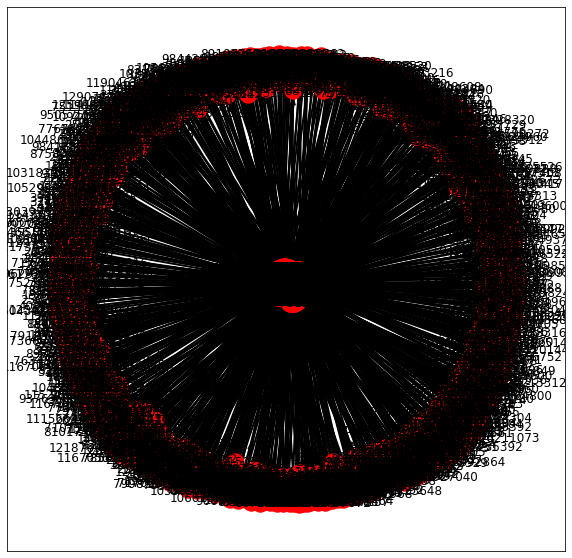

In [11]:
#Provo a disegnarlo (non scritto nella consegna)

rcParams['figure.figsize'] = 10,10

nx.draw_networkx(
    oriented,
    pos = nx.spring_layout(oriented),
    node_color = "#FF0000",
    width = 2,
    edge_cmap = plt.cm.Blues,
    with_labels = True
)
plt.show()
plt.close()

In [ ]:
new = pd.read_csv("sourceTargetULTIMATE.csv")
old = pd.read_csv("usersDetailsULTIMATE.csv")

new2 = []

for index,row in new.iterrows():
    new2.append(row['target'])
    


for index,row in old.iterrows():
    if row['id'] not in new2:
        print(row['id'])



In [ ]:
datogliere = Functions.read_json(f"{data_folder}/prensente.json")
qua = pd.read_csv("usersDetailsULTIMATE.csv")

print(len(datogliere))
print(len(qua))

for item in datogliere:
    for index,row in qua.iterrows():
        if row['id'] == item:
            qua.drop([index],axis=0,inplace=True)

print(len(qua))